In [3]:
import jsbsim
import numpy as np
from math import pi

class Actions:
    def __init__(self) -> None:
        self.table = {"sustation" : [i for i in range(169)], "position":[]}
        for i in range(13):
            for j in range(13):
                self.table["position"].append((i,j))
        self.avalible_segments = [-180, -75, -35, -15, -5, -2,-1, 1, 2, 5, 15, 35, 75, 180]
        self.avalible_segments2 = [-1, -2, -5, -10, -15, -25, -50, -180]
        self.actions = [0.025, 0.05, 0.1, 0.25, 0.33, 0.5, 0.66, 0.75]
        self.fdm = jsbsim.FGFDMExec(None)
        self.fdm.disable_output()
        self.good_steps_counter = 0

    def Reset(self):
        self.fdm = jsbsim.FGFDMExec(None)
        self.fdm.disable_output()
        self.fdm.load_script("scripts/c172_cruise_8K.xml", False)
        self.fdm["ic/theta-deg"] = (np.random.random() * (2) - 1) * 20
        self.fdm["ic/phi-deg"] = (np.random.random() * (2) - 1) * 20
        self.fdm.run_ic()
        return self.Get_state()

    def change_roll(self, angle:float):
        self.fdm["fcs/aileron-cmd-norm"] = angle

    def change_pitch(self, angle:float):
        self.fdm["fcs/elevator-cmd-norm"] = angle

    def Get_roll(self):
        return self.fdm["attitude/roll-rad"] * 180*2/pi
    
    def Get_pitch(self):
        return self.fdm["attitude/pitch-rad"] * 180*2/pi

    def _get_bin(self, angle:float) -> int:
        for i in range(len(self.avalible_segments) - 1):
            if self.avalible_segments[i] <= angle < self.avalible_segments[i+1]:
                return i
        return 12
    def Get_state(self):
        roll = self.Get_roll()
        pitch = self.Get_pitch()
        return self.table["sustation"][(self._get_bin(roll) * 13 + self._get_bin(pitch))]

    def Get_actions(self) -> list:
        roll = self.Get_roll()
        pitch = self.Get_pitch()
        sign = (lambda a: 1 if a > 0 else -1)
        for i in range(len(self.avalible_segments2)):
            if abs(roll) < abs(self.avalible_segments2[i]):
                roll_actions = self.actions[i] *  sign(roll) 
                break

        for i in range(len(self.avalible_segments2)):
            if abs(pitch) < abs(self.avalible_segments2[i]):
                pitch_actions = self.actions[i] * sign(pitch)
                break
        
        return [("roll", -roll_actions),("pitch", pitch_actions), ("double", -roll_actions, pitch_actions)] 


    def reward(self):
        roll = self.Get_roll()
        pitch = self.Get_pitch()
        r = (2 - (abs(roll)/180 + abs(pitch)/180)/2) ** 2
        if abs(roll) > 40 or abs(pitch) > 40:
            return r * 0.1
        elif abs(roll) > 20 or abs(pitch) > 20:
            return r * 0.25
        elif abs(roll) > 10 or abs(pitch) > 10:
            return r * 0.5
        elif abs(roll) > 5 or abs(pitch) > 5:
            return r * 0.75
        elif abs(roll) > 1 or abs(pitch) > 1:
            return r * 0.9
        else:
            return 1
    
    def Step(self, tup):
        if tup[0] == "double":
            self.change_roll(tup[1])
            self.change_pitch(tup[2])
        elif tup[0] == "roll":
            self.change_roll(tup[1])
        else:
            self.change_pitch(tup[1])
        reward = self.reward()
        done = False
        if self.Get_roll() > 1 or self.Get_roll() < -1 or self.Get_pitch() > 1 or self.Get_pitch() < -1:
            self.good_steps_counter = 0
        else:
            self.good_steps_counter += 1

        if self.good_steps_counter == 10:
            done = True
        # done = (lambda Roll, Pitch: True if -1 < Roll and Roll > 1\
        #     and -1 < Pitch and Pitch > 1 else False) (self.Get_roll(), self.Get_pitch())
        return self.Get_state(), reward, done
    
import math
from collections import defaultdict
import numpy as np
import time

class QLearningAgent:
   
    def __init__(self, alpha, epsilon, discount, actions:Actions) -> None:
        self._q_values = defaultdict(lambda: defaultdict(lambda : 0))
        self.alpha = alpha # lr = 0.01
        self.discount = discount # gamma = 0.95
        self.epsilon = epsilon #eps = 0.5
        self.actions = actions

    def Set_q_value(self, state, action, value):
        self._q_values[state][action] = value

    def Get_q_value(self, state, action):
        return self._q_values[state][action]

    def Get_value(self):
        actions = self.actions.Get_actions()
        state = self.actions.Get_state()
        value = max([self.Get_q_value(state, action) for action in actions])
        return value

    def Policy(self):
        state = self.actions.Get_state()
        actions = self.actions.Get_actions()
        best_action = actions[0]
        for action in actions:
            if self.Get_q_value(state, action) > self.Get_q_value(state, best_action):
                best_action = action
        return best_action
            
    def Get_action(self):
        actions = self.actions.Get_actions()
        if np.random.random() < self.epsilon:
            action = actions[np.random.choice([i for i in range(len(actions))], 1)[0]]
        else:
            action = self.Policy()
        return action
    
    def Update(self, state, action, reward):
        self.epsilon -= 0.00001
        addition = self.alpha*(reward + self.discount *(self.Get_value()-self.Get_q_value(state, action)))
        reference_value = self.Get_q_value(state, action) + addition
        self.Set_q_value(state, action, reference_value)

from collections import deque
from tqdm import tqdm

def interact(acts:Actions, agent:QLearningAgent, num_episodes=1000):
    average_reward_per_100_episodes = []
    best_average_reward_per_100_episodes = []
    avg_rewards = deque(maxlen=num_episodes)
    best_avg_reward = -math.inf
    rewards = deque(maxlen=5000)

    for episode in tqdm(range(num_episodes)):
        state = acts.Reset()
        
        counter = 0
        curr_reward = 0
        agent.epsilon = 1
        while acts.fdm.run():
            counter += 1    
            action = agent.Get_action()
            next_state, reward, done = acts.Step(action)
            agent.Update(next_state, action, reward)
            curr_reward += reward
            state = next_state
            if done:
                rewards.append(curr_reward)
                break
          
        if episode % 100 == 0:
            avg_reward = np.mean(rewards)
            avg_rewards.append(avg_reward)
            print('episode average reward {}'.format(avg_reward))
            average_reward_per_100_episodes.append(avg_reward)
            best_average_reward_per_100_episodes.append(best_avg_reward)
            
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                
            print("\rEpisode {}/{} || Best average reward {} || eps {} ".format(episode, num_episodes, best_avg_reward, agent.epsilon), end="")
    return avg_rewards, best_avg_reward

acts = Actions()
qlearn = QLearningAgent(0.06, 1, 0.95, acts)
avg_rewards, best_avg_reward = interact(acts, qlearn)

  0%|          | 0/1000 [00:00<?, ?it/s]
In file /home/anton/anaconda3/lib/python3.9/site-packages/jsbsim/systems/GNCUtilities.xml: line 68
      Property navigation/actual-heading-rad is already defined.
  0%|          | 1/1000 [00:00<02:50,  5.84it/s]This vehicle has 6 bogeys, but the current 
version of FlightGear's FGNetFDM only supports 3 bogeys.
Only the first 3 bogeys will be used.


episode average reward 4542.572587705125
Episode 0/1000 || Best average reward 4542.572587705125 || eps 0.9863300000000622 


In file /home/anton/anaconda3/lib/python3.9/site-packages/jsbsim/systems/GNCUtilities.xml: line 68
      Property navigation/actual-heading-rad is already defined.
  0%|          | 2/1000 [00:06<1:04:56,  3.90s/it]This vehicle has 6 bogeys, but the current 
version of FlightGear's FGNetFDM only supports 3 bogeys.
Only the first 3 bogeys will be used.

In file /home/anton/anaconda3/lib/python3.9/site-packages/jsbsim/systems/GNCUtilities.xml: line 68
      Property navigation/actual-heading-rad is already defined.
This vehicle has 6 bogeys, but the current 
version of FlightGear's FGNetFDM only supports 3 bogeys.
Only the first 3 bogeys will be used.
  0%|          | 3/1000 [00:12<1:16:02,  4.58s/it]
In file /home/anton/anaconda3/lib/python3.9/site-packages/jsbsim/systems/GNCUtilities.xml: line 68
      Property navigation/actual-heading-rad is already defined.
This vehicle has 6 bogeys, but the current 
version of FlightGear's FGNetFDM only supports 3 bogeys.
Only the first 3 bogeys wi

In [ ]:
import time
acts.Reset()
pitch = []
roll = []
i = 0
while acts.fdm.run():
    roll.append(acts.Get_roll())
    pitch.append(acts.Get_pitch())
    action = qlearn.Get_action()
    next_state, reward, done = acts.Step(action)
    if done:
        break
    state = next_state
    i += 1

NameError: name 'acts' is not defined

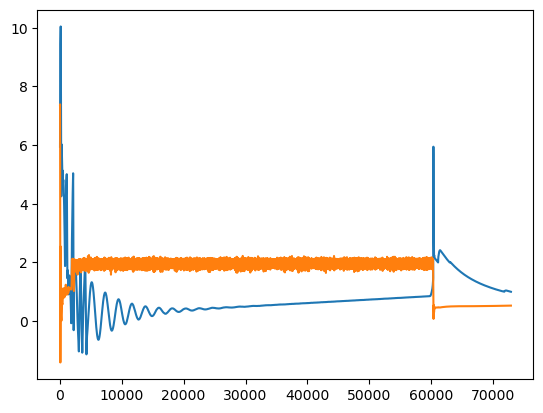

In [ ]:
pitch = np.array(pitch)
roll = np.array(roll)
xes = np.arange(len(pitch))
import matplotlib.pyplot as plt

plt.plot(xes, pitch, xes, roll)
plt.show()